In [1]:
# import all the E9 stuff
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1,
    "C:\\Users\\ken92\\Documents\\Studies\\E5\\simulation\\E9_simulations")
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

c:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\.venv\Lib\site-packages\gftool\precision.py:16: UserWarning: No quad precision datatypes available!
Some functions might be less accurate.
  warnings.warn("No quad precision datatypes available!\n"


# Atom stuff

In [2]:
Rb_atom = E9a.Rb87_5_2S1o2_F2
mu_Rb = E9c.mu_B * Rb_atom.gF * 2   # 2 here is mF = 2; sign is V = mu * B
K_atom = E9a.K40_4_2S1o2_F9o2
mu_K = E9c.mu_B * K_atom.gF * 9/2

# Unplugged magnetic trap
This section looks at different properties at a range of quadrupole field gradients
TODO: this code is pretty old, might want to go through it again

## Inputs

In [3]:
B_G_q_grad = np.linspace(5, 70)         # (For B trap) [G/cm] (xy-plane) B field gradient
N_all = 1e7                            # number of atoms; includes all spin species
Ts = [100e-6, 20e-6, 5e-6]   # Temperatures to look at
a_s = 95 * E9c.a0                       # Scattering length; need to find the reference

## Collision rates

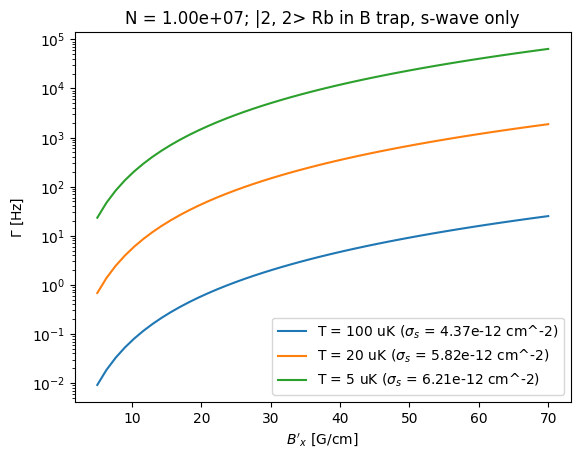

In [4]:
# print(E9n.Rb87_5_2S1o2_F2.gF * E9c.mu_B * 2 / E9c.hnobar / 1e4 / 1e6)
V_grad = B_G_q_grad * 100 * 1.4e6 * E9c.hnobar  # [J/m] potential gradient
fig = plt.figure()
ax = fig.add_subplot(111)
# xsection = 8 * np.pi * a_s**2               # making probing p.49
for T in Ts:
    n = E9ct.n_peak_lin(N_all, V_grad, T)   # peak density
    k_T = np.sqrt(E9c.k_B * T * E9c.m_Rb87) / E9c.hbar
    xsection = E9a.xsection_s(a_s, k_T, x2 = True)
    line_label = "T = {} uK (".format(int(T * 1e6)) + r"$\sigma_s$" \
                + " = {:.2e} cm^-2)".format(xsection * 1e4)
    collision_rate = E9ct.collision_rate(n, xsection, E9c.m_Rb87, T)
    ax.plot(B_G_q_grad, collision_rate, label = line_label)
    # print("T = {}: (ak)**2 = {}".format(T, (a_s * k_T)**2))
ax.set_title("N = {:.2e}; |2, 2> Rb in B trap, s-wave only".format(N_all))
ax.set_xlabel(r"$B'_x$" + " [G/cm]")
ax.set_ylabel(r"$\Gamma$" + " [Hz]")
ax.set_yscale("log")
# ax.set_ylim(0.05, 5000)
ax.legend()
# ax.hlines([1, 10], B_G_q_grad[0], B_G_q_grad[-1], colors = "k", linestyles = "--")

In [5]:
B_grad = 50. / 100
T_rf_evap = 15e-6
print(E9ct.majorana_loss_rate(E9a.Rb87_5_2S1o2_F1, B_grad, T_rf_evap))
print(E9ct.majorana_loss_rate(E9a.Rb87_5_2S1o2_F2, B_grad, T_rf_evap))
print(E9ct.majorana_loss_rate(E9a.K40_4_2S1o2_F9o2, B_grad, T_rf_evap))

print(E9ct.majorana_loss_radius(E9a.Rb87_5_2S1o2_F2, B_grad, T_rf_evap))
print(E9ct.majorana_loss_radius(E9a.K40_4_2S1o2_F9o2, B_grad, T_rf_evap))

0.16943349861108978
0.8829218790387079
2.4421213126845034
2.9440780477316416e-06
4.547228686385588e-06


# TOP trap

## Trap geometries

In [6]:
B_G_TOP_bias_range = np.array([1, 2, 3, 4]) # [G] TOP bias field
Ts = [10e-6, 5e-6, 2e-6, 1e-6]   # Temperatures to look at

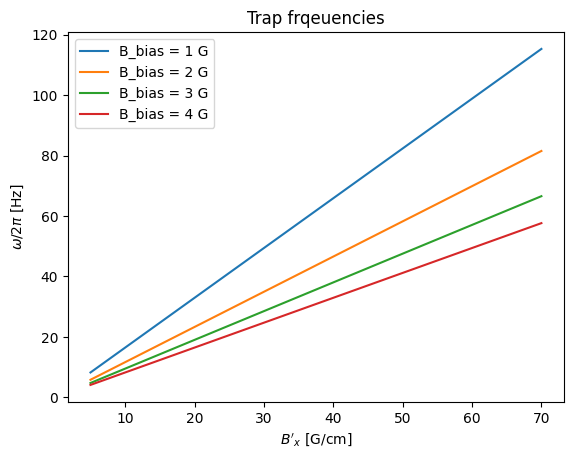

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

for B_b in B_G_TOP_bias_range:
    wbar_Rb_TOP = np.sqrt(10 / 3) * E9ct.wr_TOP(B_G_q_grad, B_b, mu_Rb, Rb_atom.mass)
    line_label = f"B_bias = {B_b} G"
    ax.plot(B_G_q_grad, wbar_Rb_TOP / 2. / np.pi, label = line_label)
ax.set_title("Trap frqeuencies")
ax.set_xlabel(r"$B'_x$" + " [G/cm]")
ax.set_ylabel(r"$\omega/2\pi$" + " [Hz]")
ax.legend()

## Collision rates

### Most general, useful when circle of death evap is used

In [8]:
def gamma_Rb_for_TOP(T, B_b, B_q_grad, N):
    wbar_TOP = np.sqrt(10 / 3) * E9ct.wr_TOP(B_q_grad, B_b, mu_Rb, Rb_atom.mass)
    n = E9ct.n_peak_har(N, wbar_TOP, T, Rb_atom.mass)   # peak density
    k_T = np.sqrt(E9c.k_B * T * E9c.m_Rb87) / E9c.hbar
    xsection = E9a.xsection_s(a_s, k_T, x2 = True)
    return E9ct.collision_rate(n, xsection, E9c.m_Rb87, T)

In [9]:
T = 0.54e-6
B_G_b = 4
B_G_q_grad = 50.
N = 1.3e5

wbar_Rb_xy = E9ct.wr_TOP(B_G_q_grad, B_G_b, mu_Rb, Rb_atom.mass)
wbar_Rb_TOP = np.sqrt(2) * wbar_Rb_xy
n_Rb_peak_TOP = E9ct.n_peak_har(N, wbar_Rb_TOP, T, Rb_atom.mass)
wbar_K_xy = E9ct.wr_TOP(B_G_q_grad, B_G_b, mu_K, K_atom.mass)
wbar_K_TOP = np.sqrt(2) * wbar_K_xy
n_K_peak_TOP = E9ct.n_peak_har(N, wbar_K_TOP, T, K_atom.mass)

print(f"T = {T * 1e6:.2f} uK, B_b = {B_G_b} G, B_grad = {B_G_q_grad} G, N = {N:.2e}")
print(f"trap frequencies (radial): w/2pi = (Rb) {wbar_Rb_xy / 2. / np.pi:.2f} (K) {wbar_K_xy / 2. / np.pi:.2f} [Hz]")
print(f"trap frequencies (g.m.): w/2pi = (Rb) {wbar_Rb_TOP / 2. / np.pi:.2f} (K) {wbar_K_TOP / 2. / np.pi:.2f} [Hz]")
print(f"peak density: {n_Rb_peak_TOP / 1e6:.2e} [1/cm^3]")
print(f"PSD = {E9ct.PSD_har(N, wbar_Rb_TOP, T, Rb_atom.mass):.2e}")
print(f"collision rate: {gamma_Rb_for_TOP(T, B_G_b, B_G_q_grad, N):.2f} [Hz]")
print(f"three-body loss rate: {6 * E9c.G3loss_Rb87_F2mF2 * n_Rb_peak_TOP**2:.4f} [Hz] (thermal)")

T = 0.54 uK, B_b = 4 G, B_grad = 50.0 G, N = 1.30e+05
trap frequencies (radial): w/2pi = (Rb) 22.55 (K) 33.26 [Hz]
trap frequencies (g.m.): w/2pi = (Rb) 31.90 (K) 47.04 [Hz]
peak density: 1.79e+11 [1/cm^3]
PSD = 2.96e-03
collision rate: 3.96 [Hz]
three-body loss rate: 0.0000 [Hz] (thermal)


### In fixed TOP trap, probably useful for the last RF only evap

In [10]:
B_G_TOP_bias = 3.5                          # [G] TOP bias field
N_all = 1e6

TypeError: 'float' object is not subscriptable

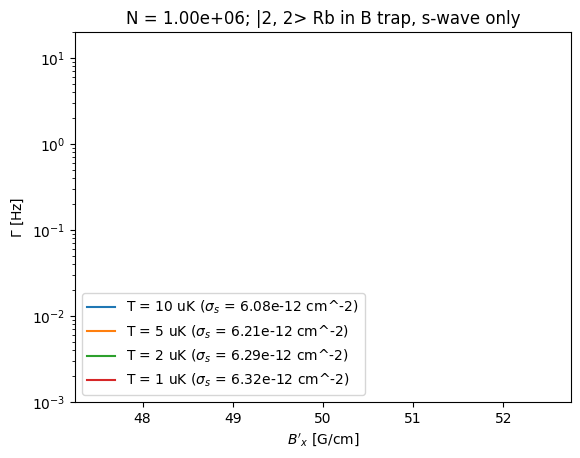

In [11]:
wbar_Rb_TOP = np.sqrt(10 / 3) * E9ct.wr_TOP(B_G_q_grad, B_G_TOP_bias, mu_Rb, Rb_atom.mass)

fig = plt.figure()
ax = fig.add_subplot(111)
for T in Ts:
    n = E9ct.n_peak_har(N_all, wbar_Rb_TOP, T, Rb_atom.mass)   # peak density
    k_T = np.sqrt(E9c.k_B * T * E9c.m_Rb87) / E9c.hbar
    xsection = E9a.xsection_s(a_s, k_T, x2 = True)
    line_label = "T = {} uK (".format(int(T * 1e6)) + r"$\sigma_s$" \
                + " = {:.2e} cm^-2)".format(xsection * 1e4)
    collision_rate = E9ct.collision_rate(n, xsection, E9c.m_Rb87, T)
    ax.plot(B_G_q_grad, collision_rate, label = line_label)
ax.set_title("N = {:.2e}; |2, 2> Rb in B trap, s-wave only".format(N_all))
ax.set_xlabel(r"$B'_x$" + " [G/cm]")
ax.set_ylabel(r"$\Gamma$" + " [Hz]")
ax.set_yscale("log")
ax.set_ylim(1e-3, 20)
ax.legend()
ax.hlines([1, 10], B_G_q_grad[0], B_G_q_grad[-1], colors = "k", linestyles = "--")